# Multiclass Network Threat Detection - CSV Training

**Goal:** Train a multiclass model using the CICIDS2017 CSV dataset.

## Attack Types Available:
- BENIGN (normal traffic)
- DDoS, PortScan
- DoS Hulk, DoS GoldenEye, DoS slowloris, DoS Slowhttptest
- FTP-Patator, SSH-Patator
- Web Attack (Brute Force, XSS, SQL Injection)
- Infiltration, Heartbleed

## Strategy:
1. Load all CSV files
2. Clean and preprocess features
3. Balance classes (undersample BENIGN, keep all attacks)
4. Train Random Forest with optimized hyperparameters
5. Evaluate and save model

In [1]:
# Setup
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path('.').resolve().parent
DATASET_DIR = BASE_DIR / 'dataset'
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Dataset directory: {DATASET_DIR}")
print(f"Models directory: {MODELS_DIR}")

Base directory: C:\Users\Ghulam Mohayudin\Projects\Others\network-based-ai
Dataset directory: C:\Users\Ghulam Mohayudin\Projects\Others\network-based-ai\dataset
Models directory: C:\Users\Ghulam Mohayudin\Projects\Others\network-based-ai\models


## Step 1: Define Features (78 CICFlowMeter features)

In [2]:
# CICIDS2017 Feature Names (78 features)
CICIDS2017_FEATURES = [
    'Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean',
    'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
    'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
    'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
    'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
    'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
    'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
    'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean',
    'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]

print(f"Total features: {len(CICIDS2017_FEATURES)}")

Total features: 78


## Step 2: Load All CSV Files

In [3]:
# CSV files to load
csv_files = [
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
]

# Check which files exist
print("Checking CSV files:")
for f in csv_files:
    path = DATASET_DIR / f
    if path.exists():
        size_mb = path.stat().st_size / (1024**2)
        print(f"  ✅ {f} ({size_mb:.1f} MB)")
    else:
        print(f"  ❌ {f} NOT FOUND")

Checking CSV files:
  ✅ Monday-WorkingHours.pcap_ISCX.csv (168.7 MB)
  ✅ Tuesday-WorkingHours.pcap_ISCX.csv (128.8 MB)
  ✅ Wednesday-workingHours.pcap_ISCX.csv (214.7 MB)
  ✅ Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (49.6 MB)
  ✅ Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (79.3 MB)
  ✅ Friday-WorkingHours-Morning.pcap_ISCX.csv (55.6 MB)
  ✅ Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (73.3 MB)
  ✅ Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (73.6 MB)


In [4]:
def load_csv_safe(filepath):
    """Load CSV with proper column handling."""
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.strip()  # Remove whitespace from column names
    return df

# Load all CSV files
print("Loading CSV files...")
dataframes = []

for csv_file in csv_files:
    filepath = DATASET_DIR / csv_file
    if filepath.exists():
        print(f"  Loading {csv_file}...")
        df = load_csv_safe(filepath)
        print(f"    Rows: {len(df):,}")
        print(f"    Labels: {df['Label'].value_counts().to_dict()}")
        dataframes.append(df)
    else:
        print(f"  ⚠️ Skipping {csv_file} (not found)")

print(f"\n✅ Loaded {len(dataframes)} CSV files")

Loading CSV files...
  Loading Monday-WorkingHours.pcap_ISCX.csv...
    Rows: 529,918
    Labels: {'BENIGN': 529918}
  Loading Tuesday-WorkingHours.pcap_ISCX.csv...
    Rows: 445,909
    Labels: {'BENIGN': 432074, 'FTP-Patator': 7938, 'SSH-Patator': 5897}
  Loading Wednesday-workingHours.pcap_ISCX.csv...
    Rows: 692,703
    Labels: {'BENIGN': 440031, 'DoS Hulk': 231073, 'DoS GoldenEye': 10293, 'DoS slowloris': 5796, 'DoS Slowhttptest': 5499, 'Heartbleed': 11}
  Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
    Rows: 170,366
    Labels: {'BENIGN': 168186, 'Web Attack � Brute Force': 1507, 'Web Attack � XSS': 652, 'Web Attack � Sql Injection': 21}
  Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
    Rows: 288,602
    Labels: {'BENIGN': 288566, 'Infiltration': 36}
  Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
    Rows: 191,033
    Labels: {'BENIGN': 189067, 'Bot': 1966}
  Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...

In [5]:
# Combine all dataframes
print("Combining datasets...")
df_all = pd.concat(dataframes, ignore_index=True)
print(f"Total rows: {len(df_all):,}")
print(f"Total columns: {len(df_all.columns)}")

# Show label distribution
print("\nLabel distribution:")
label_counts = df_all['Label'].value_counts()
print(label_counts)

Combining datasets...
Total rows: 2,830,743
Total columns: 79

Label distribution:
Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


## Step 3: Data Cleaning

In [6]:
# Clean labels (strip whitespace)
df_all['Label'] = df_all['Label'].str.strip()

# Group similar attack types for simplicity (optional)
# You can comment this out if you want full granularity
label_mapping = {
    # Keep as-is
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'PortScan': 'PortScan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    
    # Group DoS variants
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'Heartbleed': 'DoS',
    
    # Group Web Attacks
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    
    # Keep Infiltration
    'Infiltration': 'Infiltration',
}

# Apply mapping
df_all['Label_Grouped'] = df_all['Label'].map(label_mapping)

# Check for unmapped labels
unmapped = df_all[df_all['Label_Grouped'].isna()]['Label'].unique()
if len(unmapped) > 0:
    print(f"⚠️ Unmapped labels: {unmapped}")
    # Map any unmapped to 'Other'
    df_all['Label_Grouped'] = df_all['Label_Grouped'].fillna('Other')

print("\nGrouped label distribution:")
print(df_all['Label_Grouped'].value_counts())

⚠️ Unmapped labels: ['Bot']

Grouped label distribution:
Label_Grouped
BENIGN          2273097
DoS              252672
PortScan         158930
DDoS             128027
Brute Force       13835
Web Attack         2180
Other              1966
Infiltration         36
Name: count, dtype: int64


In [7]:
# Select only the features we need
available_features = [f for f in CICIDS2017_FEATURES if f in df_all.columns]
missing_features = [f for f in CICIDS2017_FEATURES if f not in df_all.columns]

print(f"Available features: {len(available_features)}/{len(CICIDS2017_FEATURES)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Create feature matrix
X = df_all[available_features].copy()
y = df_all['Label_Grouped'].copy()  # Use grouped labels

print(f"\nFeature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

Available features: 78/78

Feature matrix shape: (2830743, 78)
Label vector shape: (2830743,)


In [8]:
# Handle missing and infinite values
print("Cleaning data...")
print(f"  Missing values before: {X.isnull().sum().sum():,}")
print(f"  Infinite values before: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum():,}")

# Replace infinities with NaN, then fill NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"  Missing values after: {X.isnull().sum().sum():.0f}")
print(f"  Infinite values after: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum():.0f}")

Cleaning data...
  Missing values before: 1,358
  Infinite values before: 4,376
  Missing values after: 0
  Infinite values after: 0


## Step 4: Balance Classes

In [9]:
from sklearn.utils import resample

# Current class distribution
print("Current class distribution:")
print(y.value_counts())

# Balance strategy:
# - BENIGN is heavily overrepresented, undersample to max 200K
# - Keep all attack samples (they are minority)
# - Oversample very rare attacks to minimum 1000 samples

MAX_BENIGN = 200000
MIN_ATTACK = 1000

balanced_dfs = []

for label in y.unique():
    df_class = pd.concat([X[y == label], y[y == label]], axis=1)
    n_samples = len(df_class)
    
    if label == 'BENIGN':
        if n_samples > MAX_BENIGN:
            df_class = resample(df_class, n_samples=MAX_BENIGN, random_state=42, replace=False)
            print(f"  {label}: {n_samples:,} -> {MAX_BENIGN:,} (undersampled)")
        else:
            print(f"  {label}: {n_samples:,} (kept)")
    else:
        if n_samples < MIN_ATTACK:
            df_class = resample(df_class, n_samples=MIN_ATTACK, random_state=42, replace=True)
            print(f"  {label}: {n_samples:,} -> {MIN_ATTACK:,} (oversampled)")
        else:
            print(f"  {label}: {n_samples:,} (kept)")
    
    balanced_dfs.append(df_class)

# Combine balanced data
df_balanced = pd.concat(balanced_dfs, ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

X_balanced = df_balanced.drop(columns=['Label_Grouped'])
y_balanced = df_balanced['Label_Grouped']

print(f"\nBalanced dataset: {len(df_balanced):,} samples")
print(y_balanced.value_counts())

Current class distribution:
Label_Grouped
BENIGN          2273097
DoS              252672
PortScan         158930
DDoS             128027
Brute Force       13835
Web Attack         2180
Other              1966
Infiltration         36
Name: count, dtype: int64
  BENIGN: 2,273,097 -> 200,000 (undersampled)
  Brute Force: 13,835 (kept)
  DoS: 252,672 (kept)
  Web Attack: 2,180 (kept)
  Infiltration: 36 -> 1,000 (oversampled)
  Other: 1,966 (kept)
  PortScan: 158,930 (kept)
  DDoS: 128,027 (kept)

Balanced dataset: 758,610 samples
Label_Grouped
DoS             252672
BENIGN          200000
PortScan        158930
DDoS            128027
Brute Force      13835
Web Attack        2180
Other             1966
Infiltration      1000
Name: count, dtype: int64


## Step 5: Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

print("\nTraining label distribution:")
print(y_train.value_counts())

Training set: 606,888 samples
Test set: 151,722 samples

Training label distribution:
Label_Grouped
DoS             202137
BENIGN          160000
PortScan        127144
DDoS            102422
Brute Force      11068
Web Attack        1744
Other             1573
Infiltration       800
Name: count, dtype: int64


## Step 6: Train Random Forest (Optimized)

In [11]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest Classifier...")
print("="*60)
print("Using optimized hyperparameters for smaller model size")

# Optimized hyperparameters for smaller model
rf_model = RandomForestClassifier(
    n_estimators=50,        # Reduced from 100 for smaller model
    max_depth=20,           # Limit depth to prevent overfitting and reduce size
    min_samples_split=10,   # Require more samples to split
    min_samples_leaf=5,     # Require more samples in leaf nodes
    max_features='sqrt',    # Use sqrt of features for each tree
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1
)

start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training Random Forest Classifier...
Using optimized hyperparameters for smaller model size


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.6s



✅ Training completed in 33.37 seconds (0.56 minutes)


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.4s finished


## Step 7: Evaluate Model

In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

print("="*60)
print("MODEL PERFORMANCE (Test Set)")
print("="*60)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.2s finished


MODEL PERFORMANCE (Test Set)
Accuracy: 0.9978 (99.78%)

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00     40000
 Brute Force       1.00      1.00      1.00      2767
        DDoS       1.00      1.00      1.00     25605
         DoS       1.00      1.00      1.00     50535
Infiltration       1.00      1.00      1.00       200
       Other       0.63      0.99      0.77       393
    PortScan       1.00      1.00      1.00     31786
  Web Attack       0.99      0.98      0.98       436

    accuracy                           1.00    151722
   macro avg       0.95      1.00      0.97    151722
weighted avg       1.00      1.00      1.00    151722



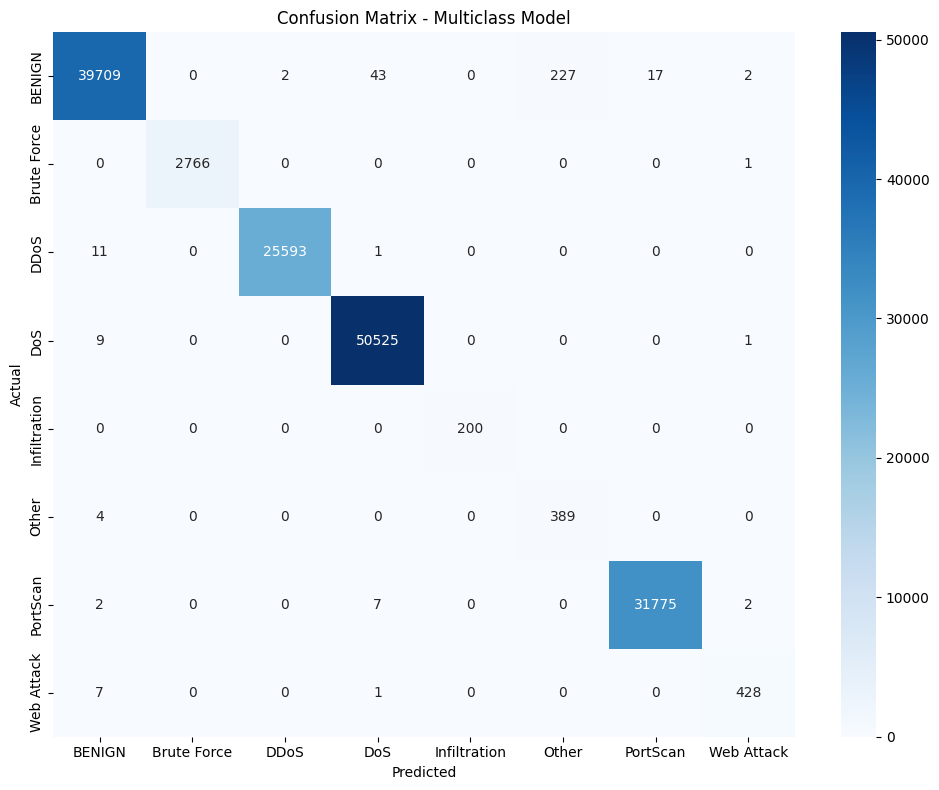

In [13]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
class_names = sorted(y_test.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Multiclass Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Step 8: Save Model

In [14]:
import joblib

# Save model
model_path = MODELS_DIR / 'random_forest_multiclass_cicids.joblib'
joblib.dump(rf_model, model_path)

# Save feature names
feature_names_path = MODELS_DIR / 'feature_names_multiclass_cicids.joblib'
joblib.dump(list(X_train.columns), feature_names_path)

# Save class names
class_names_path = MODELS_DIR / 'class_names_multiclass_cicids.joblib'
joblib.dump(sorted(y_train.unique().tolist()), class_names_path)

# Check model size
model_size_mb = model_path.stat().st_size / (1024**2)

print("="*60)
print("MODEL SAVED")
print("="*60)
print(f"Model: {model_path}")
print(f"Size: {model_size_mb:.2f} MB")
print(f"Features: {len(X_train.columns)}")
print(f"Classes: {sorted(y_train.unique().tolist())}")
print("="*60)

MODEL SAVED
Model: C:\Users\Ghulam Mohayudin\Projects\Others\network-based-ai\models\random_forest_multiclass_cicids.joblib
Size: 9.57 MB
Features: 78
Classes: ['BENIGN', 'Brute Force', 'DDoS', 'DoS', 'Infiltration', 'Other', 'PortScan', 'Web Attack']


## Step 9: Feature Importance

Top 20 Most Important Features:
                    feature  importance
           Destination Port    0.098770
    Init_Win_bytes_backward    0.067770
     Fwd Packet Length Mean    0.035997
     Init_Win_bytes_forward    0.032812
      Fwd Packet Length Max    0.031460
Total Length of Fwd Packets    0.031385
          Subflow Fwd Bytes    0.031034
     Bwd Packet Length Mean    0.028324
          Max Packet Length    0.027412
        Average Packet Size    0.026017
       Avg Fwd Segment Size    0.025836
              Bwd Packets/s    0.025307
      Fwd Packet Length Std    0.025035
         Packet Length Mean    0.024162
          Packet Length Std    0.021242
       min_seg_size_forward    0.019832
      Bwd Packet Length Max    0.019603
               Flow IAT Max    0.019048
      Bwd Packet Length Min    0.018630
     Packet Length Variance    0.018562


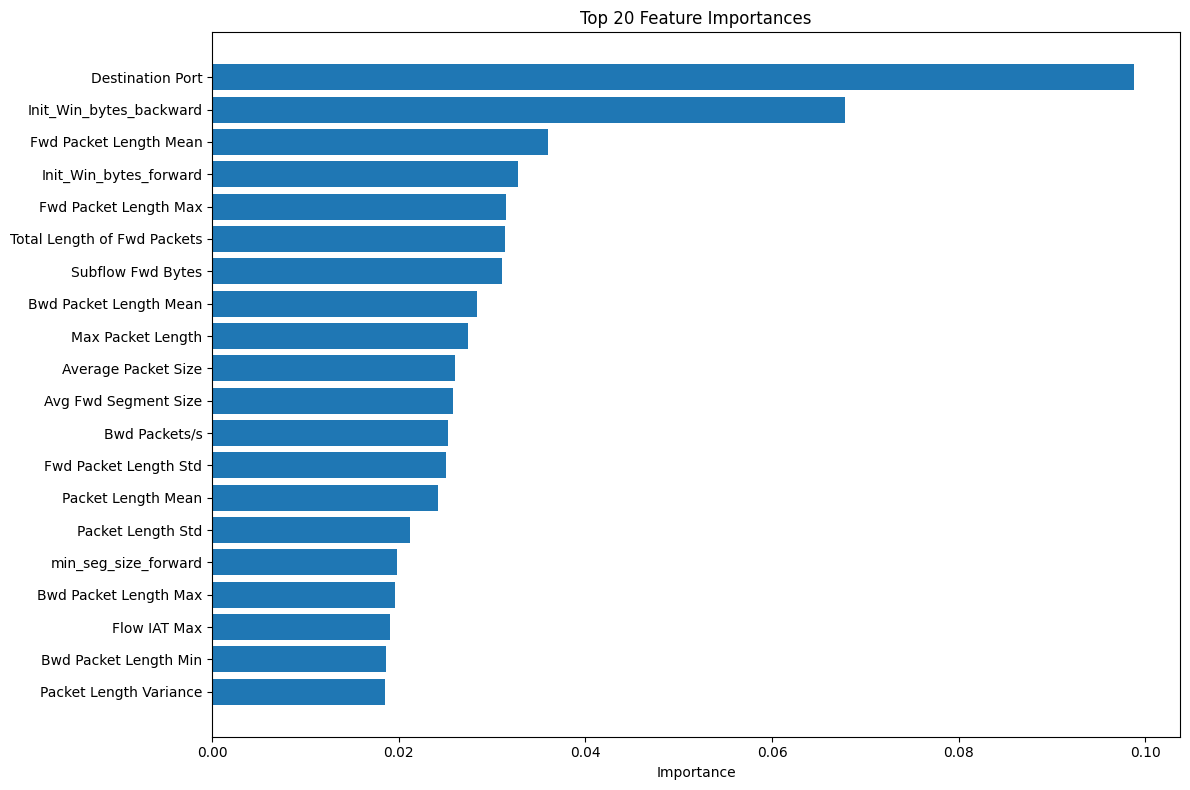

In [15]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importance.head(20)['feature'][::-1], 
         feature_importance.head(20)['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

## Summary

**Model trained successfully!**

### Next Steps:
1. Update `src/predictor.py` to load this new model
2. Update `src/feature_extractor.py` to use CICFlowMeter plugin for PCAP extraction
3. Test on real PCAP files

### Model Files:
- `models/random_forest_multiclass_cicids.joblib`
- `models/feature_names_multiclass_cicids.joblib`
- `models/class_names_multiclass_cicids.joblib`